In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

import os
import time
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import itertools
import scanpy as sc
from truncated_normal import truncated_normal as tn
from scipy.stats import ttest_ind

import figure_utils as utils

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load data
def load_mat_h5f(flname):
    h5f = h5py.File(flname,'r')
    X = h5f['dataset_1'][:]
    h5f.close()
    return X


def load_dataset(dirname, pref, get_features=False):
    
    X_path = os.path.join(dirname, pref, '%s_expr.txt'%(pref))
    Y_path = os.path.join(dirname, pref, '%s_labels.txt'%(pref))
    features_path = os.path.join(dirname, pref, '%s_features.txt'%(pref))

    if os.path.isfile(Y_path):
        Y = np.loadtxt(Y_path, dtype=str, delimiter='aSDFASDF')
    else:
        print('No labels found. Exiting.')
        return
    
    if os.path.isfile(X_path.replace('.txt', '.h5')):
        X = load_mat_h5f(X_path.replace('.txt', '.h5'))
    elif os.path.isfile(X_path):
        X = np.loadtxt(X_path).T
    else:
        print('No data found. Exiting.')
        return
       
    if get_features and os.path.isfile(features_path):
        features = np.loadtxt(features_path, dtype=str)
        return X, Y, features
    
    return X, Y

In [3]:
datasets = [
    '10x',
    'Biase',
    'Birey',
    'Buettner',
    'Deng',
    'DropSeq',
    'inDrop',
    'Joost',
    'Kiselev',
    'Kolodziejczyk',
    'Patel',
    'Pollen',
    'Resolve',
    'Ting',
    'Treutlein',
    'Usoskin',
    'Yan',
    'Zeisel'
]

dirname = '/root/mount/datasets/'

In [4]:
pref = 'Zeisel'
X, _, features = load_dataset(dirname, pref, get_features=True)
Y_path = os.path.join(dirname, pref, 'Zeisel_labels_level2class.txt')
Y = np.loadtxt(Y_path, dtype=str, delimiter='aSDFASDF')
tsne = np.loadtxt(os.path.join(dirname, 'Zeisel/Zeisel_reducedim_coor.txt'))

In [5]:
# Preprocess using scanpy
adata = sc.AnnData(X=X)
adata.var['genes_ids'] = features
adata.obs['n_counts'] = adata.X.sum(axis=1)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['n_counts'])

In [6]:
types_of_interest = ['Int%s'%(i) for i in range(1, 17)]
genes_of_interest = [
    'Pvalb',
    'Sst',
    'Htr3a',
    'Vip',
    'Reln',
    'Cck',
    'Npy',
    'Lhx6',
    'Calb1',
    'Calb2',
    'Penk',
    'Cdh13',
    'Igfbp4',
    'Pde1a',
    'Lphn2',
    'Kcnip2',
    'Rgs10',
    'Nov',
    'Cpne5',
    'Slc5a7',
    'Crh',
    'Fut9',
    'Pax6',
    'Cxcl14',
    'Gda',
    'Sema3e'
]

genes_to_test = [np.where(features == gene)[0][0] for gene in genes_of_interest]

In [7]:
def f(tup):
    np.random.seed(0)
    ident0, ident1, adata, Y, genes_to_test = tup
    print(ident0, ident1)
    # Split preprocessed data
    y = adata.X[Y == ident0]
    z = adata.X[Y == ident1]

    # TN test using existing labels
    p_t = ttest_ind(y, z)[1][genes_to_test]
    p_tn, consistency = tn.tn_test(y, z,
                                   genes_to_test=genes_to_test,
                                   split_prop=0.5,
                                   eps=1e-2,
                                   verbose=True,
                                   learning_rate=1.,
                                   num_iters=10000,
                                   return_consistency=True)
    
    filename = 'parallelization_temp_files/%sv%s'%(ident0, ident1)
    np.save(filename, (p_t, p_tn, consistency))
    
# Test the function
# for ident0, ident1 in itertools.combinations(types_of_interest, 2):
#     tup = (ident0, ident1, adata, Y, genes_to_test)
#     f(tup)

In [9]:
# for i, gene in enumerate(features[genes_to_test]):
#     print('%10s\tt-test p = %.3e\tTN test p = %.3e\tratio = %.3f'%(gene, p_t[i], p_tn[i], p_tn[i]/p_t[i]))

# Get colormaps for each gene

num_classes = len(np.unique(types_of_interest))

ratios = np.zeros((len(types_of_interest), len(types_of_interest), len(genes_to_test)))
consistencies = np.zeros((len(types_of_interest), len(types_of_interest)))
type_to_idx = {t:i for i, t in enumerate(types_of_interest)}

dicts = {gene:{'Cluster 1':[], 'Cluster 2':[], 'ratio':[]} for gene in features[genes_to_test]}
vmax = 0

for ident0, ident1 in itertools.combinations(types_of_interest, 2):
    filename = 'parallelization_temp_files/%sv%s.npy'%(ident0, ident1)
    
    p_t, p_tn, consistency = np.load(filename)
    
    consistencies[type_to_idx[ident0], type_to_idx[ident1]] = consistency
    consistencies[type_to_idx[ident1], type_to_idx[ident0]] = consistency
    
    for i, gene in enumerate(features[genes_to_test]):
        if consistency > thresh:
            ratio = np.max((-np.log10(p_t[i]/p_tn[i]), 0))
        else:
            ratio = 0
        dicts[gene]['Cluster 1'].append(ident0)
        dicts[gene]['Cluster 2'].append(ident1)
        dicts[gene]['ratio'].append(ratio)
        dicts[gene]['Cluster 1'].append(ident1)
        dicts[gene]['Cluster 2'].append(ident0)
        dicts[gene]['ratio'].append(ratio)
        
        ratios[type_to_idx[ident0], type_to_idx[ident1], i] = ratio
        ratios[type_to_idx[ident1], type_to_idx[ident0], i] = ratio
        
        if ratio > vmax:
            vmax = ratio

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.325


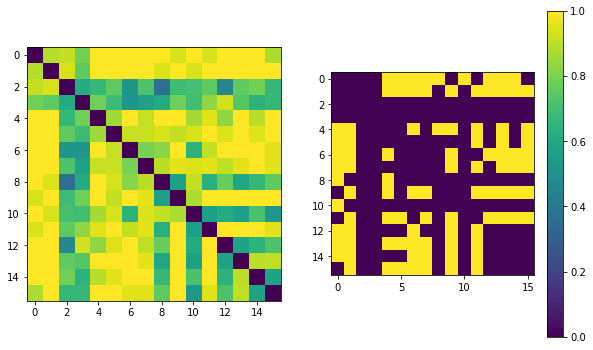

In [10]:
from scipy.special import comb
comb(16, 2)

thresh = 0.95

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(consistencies)
plt.subplot(1, 2, 2)
plt.imshow((consistencies > thresh).astype(int))
plt.colorbar()

num_above_thresh = (np.sum(consistencies > thresh)-len(types_of_interest))/2
print(num_above_thresh/comb(len(types_of_interest), 2))

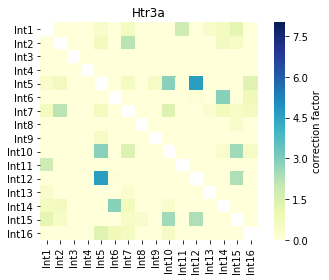

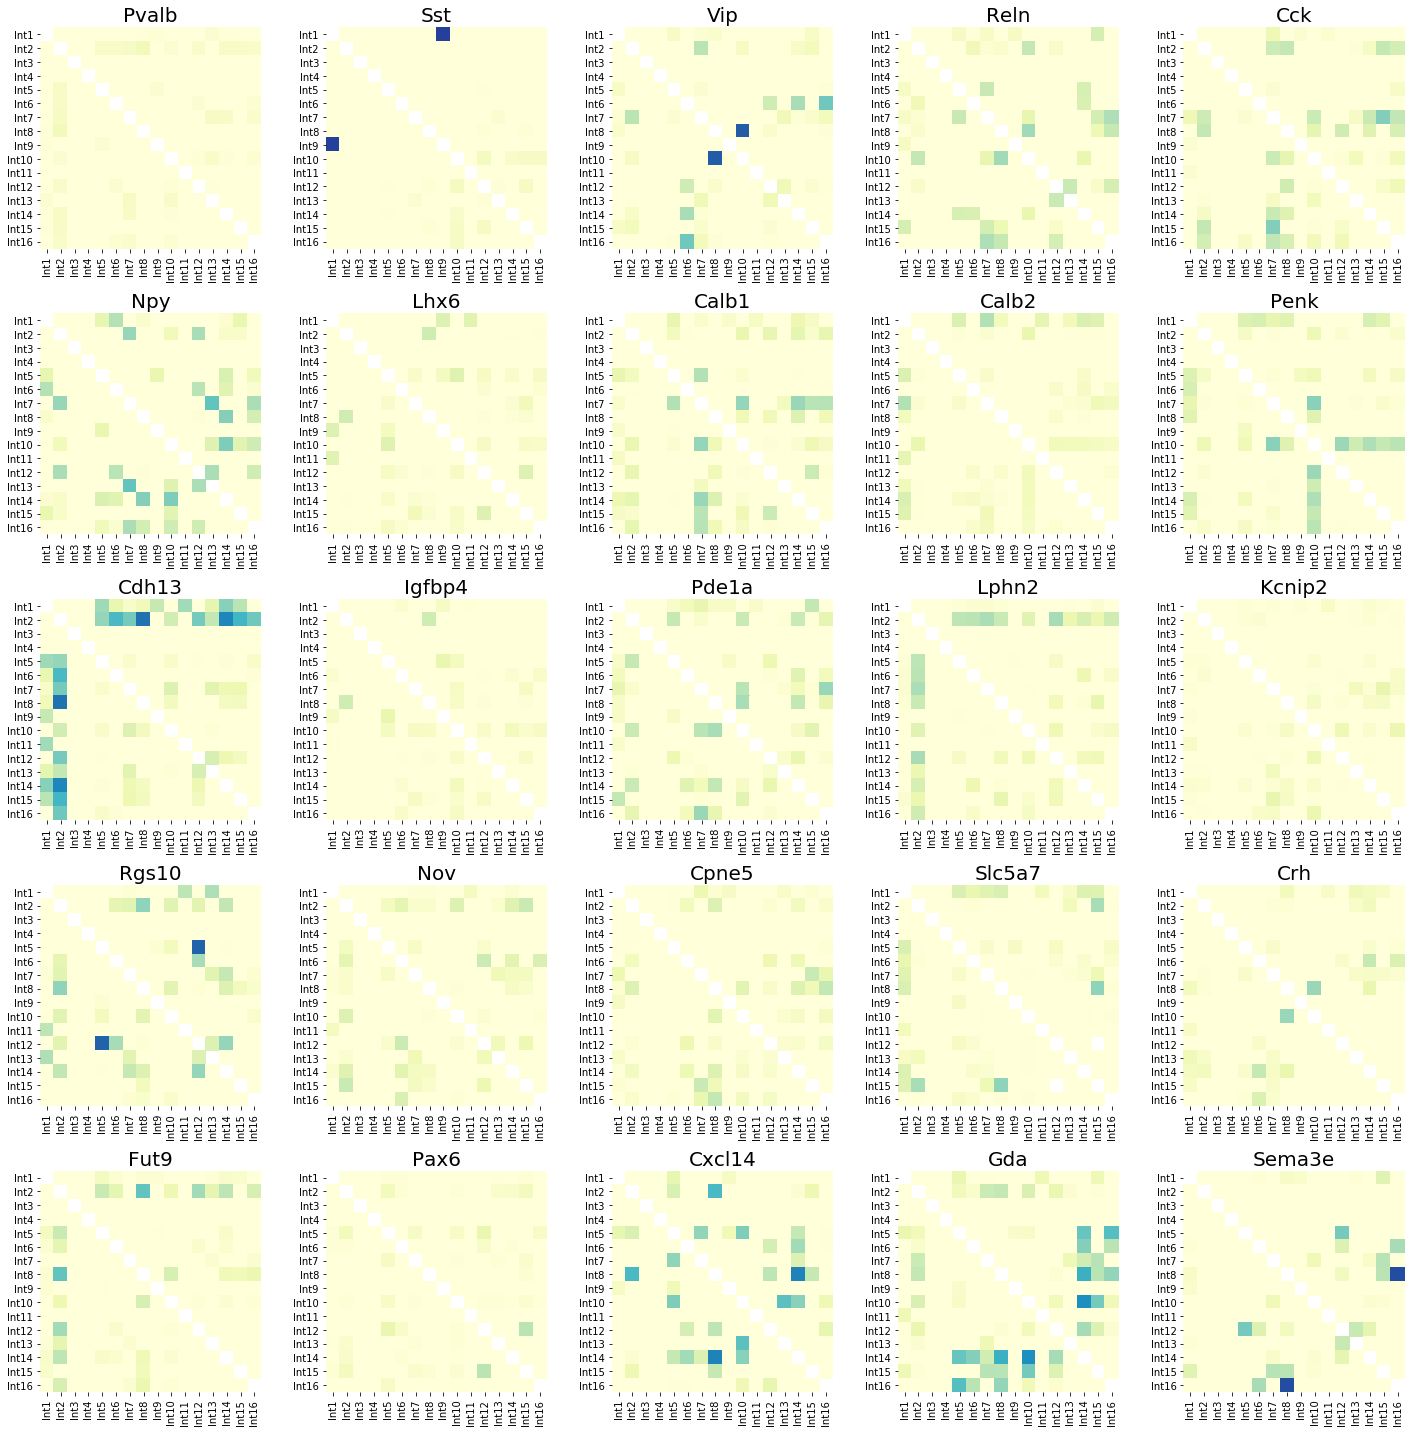

In [11]:
chosen_gene = 'Htr3a'
data = pd.DataFrame.from_dict(dicts[chosen_gene])
sb.heatmap(data.pivot("Cluster 1", "Cluster 2", "ratio")[types_of_interest].T[types_of_interest],
           square=True, vmin=0, vmax=8, cmap="YlGnBu", cbar_kws={'label': 'correction factor'})
plt.xlabel('')
plt.ylabel('')
plt.title(chosen_gene)
plt.savefig('figures/Zeisel_%s.pdf'%(chosen_gene), format='pdf', dpi=500, bbox_inches='tight')
plt.show()
vmax = 8 #np.max(data)['ratio']

plt.figure(figsize=(20, 20))
plot_count = 0
for i, gene in enumerate(genes_of_interest):
    if gene != chosen_gene:
        plt.subplot(5, 5, plot_count+1)
        data = pd.DataFrame.from_dict(dicts[gene])
        sb.heatmap(data.pivot("Cluster 1", "Cluster 2", "ratio")[types_of_interest].T[types_of_interest],
                   square=True, vmin=0, vmax=vmax, cbar=False, cmap="YlGnBu")
        plt.xlabel('')
        plt.ylabel('')
        plt.title(gene, fontsize=20)
        plot_count += 1
plt.tight_layout()
plt.savefig('figures/Zeisel_colormaps.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

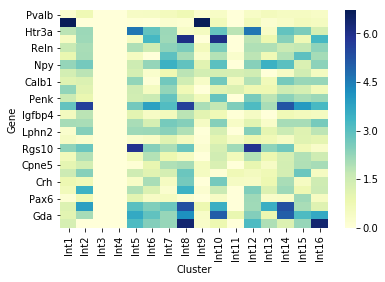

In [12]:
# Collapse heatmap a bit
collapsed = {'Cluster':[], 'Gene':[], 'Max CF':[]}
for i, gene in enumerate(genes_of_interest):
    data = pd.DataFrame.from_dict(dicts[gene])
    data = data.pivot("Cluster 1", "Cluster 2", "ratio")[types_of_interest].T[types_of_interest]
    max_cf = np.max(data, 1)
    for i, clust in enumerate(data.index):
        collapsed['Cluster'].append(clust)
        collapsed['Gene'].append(gene)
        collapsed['Max CF'].append(max_cf[i])
collapsed = pd.DataFrame.from_dict(collapsed)
collapsed_pivot = collapsed.pivot("Cluster", "Gene", "Max CF")[genes_of_interest].T[types_of_interest]
sb.heatmap(collapsed_pivot, cmap="YlGnBu", cbar=True)
plt.savefig('figures/Zeisel_collapsed_colormaps.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

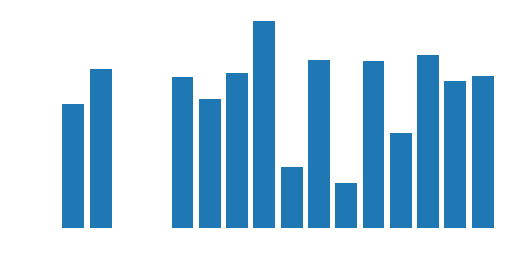

In [13]:
fig, ax = plt.subplots(figsize=(8.5, 4))
rects = ax.bar(np.arange(len(types_of_interest)),
               np.sum(collapsed_pivot, 0),
               0.8,
               align='center')
ax.set_ylabel('correction factor')
xticks_pos = [0.65*patch.get_width()+patch.get_xy()[0]-0.05 for patch in rects]
plt.xticks(np.array(xticks_pos), types_of_interest, rotation=90)
plt.axis('off')
plt.savefig('figures/Zeisel_correction_factors.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()